# Imports

In [1]:
import os
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt


# Variables

In [2]:
BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (224, 224)
SEED = 42

train_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/train")
test_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/test")
val_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid")

# Setup Dataset

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

Found 5789 files belonging to 57 classes.
Found 1448 files belonging to 57 classes.
Found 1810 files belonging to 57 classes.


2024-10-21 09:41:19.607083: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-21 09:41:19.607112: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-21 09:41:19.607120: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-21 09:41:19.607133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-21 09:41:19.607145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# View Some Images

In [6]:
class_names = train_ds.class_names

plt.figure(figsize=(15, 10))
#for images, labels in train_ds.take(1):
#  for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(images[i].numpy().astype("uint8"))
#    plt.title(class_names[labels[i]])
#    plt.axis("off")

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

# AutoTune Dataset

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [8]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        #tf.keras.layers.GaussianNoise(0.2),
    ]
)

## View Augmented Images

2024-10-21 09:41:42.636041: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


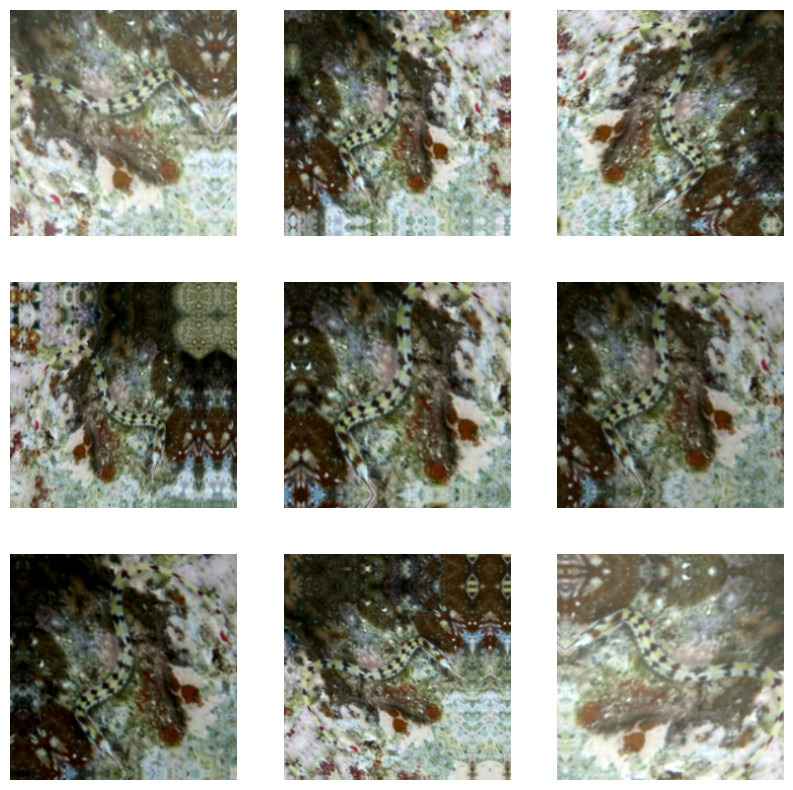

In [9]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
# MobileNetV2 Image Preprocessing
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create Base Model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

In [11]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [12]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs) 
x = preprocess_input(x) 
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(57, activation='softmax', name='output')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 57)             │        73,017 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,331,001 (8.89 MB)

 Trainable params: 73,017 (285.22 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
base_learning_rate = 0.0001
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
  loss="categorical_crossentropy", 
  metrics=['accuracy'],
)

In [14]:
loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2024-10-21 09:41:44.986407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.0104 - loss: 4.6590
initial loss: 4.67
initial accuracy: 0.01


In [15]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.0530 - loss: 4.2542 - val_accuracy: 0.1892 - val_loss: 3.3615
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 137ms/step - accuracy: 0.2048 - loss: 3.2730 - val_accuracy: 0.3584 - val_loss: 2.7530
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 137ms/step - accuracy: 0.3389 - loss: 2.7151 - val_accuracy: 0.4772 - val_loss: 2.3294
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 137ms/step - accuracy: 0.4353 - loss: 2.3126 - val_accuracy: 0.5628 - val_loss: 2.0289
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.5170 - loss: 2.0245 - val_accuracy: 0.6209 - val_loss: 1.8006
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 140ms/step - accuracy: 0.5644 - loss: 1.8224 - val_accuracy: 0.6526 - val_loss: 1.6309
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - accuracy: 0.6072 - loss: 1.6465 - val_accuracy: 0.6768 - val_loss: 1.4937
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - accuracy: 0.6345 - loss: 1

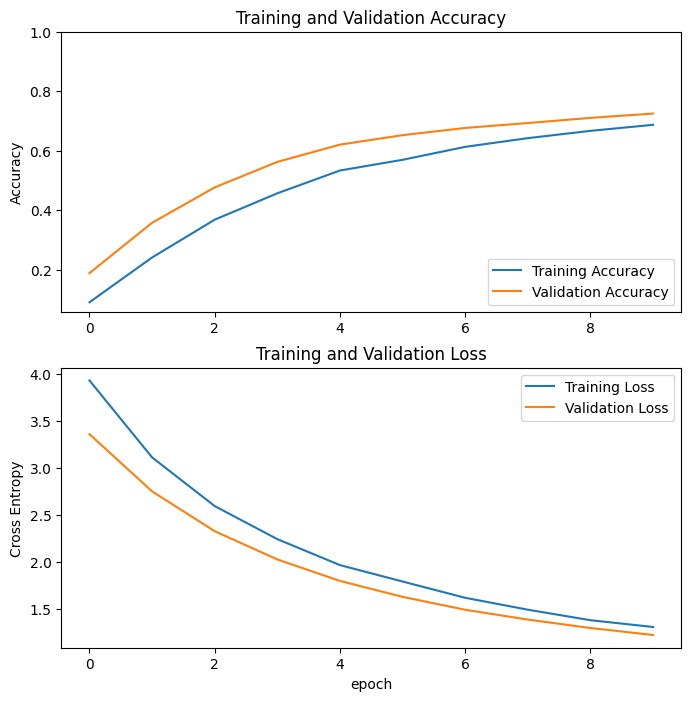

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [17]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [18]:
model.compile(
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
  loss="categorical_crossentropy", 
  metrics=['accuracy'],
)

In [19]:
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds)

Epoch 11/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 47s 214ms/step - accuracy: 0.5532 - loss: 1.8408 - val_accuracy: 0.7341 - val_loss: 1.0264
Epoch 12/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 37s 202ms/step - accuracy: 0.6769 - loss: 1.3559 - val_accuracy: 0.7445 - val_loss: 0.9317
Epoch 13/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 36s 200ms/step - accuracy: 0.7240 - loss: 1.1277 - val_accuracy: 0.7583 - val_loss: 0.8608
Epoch 14/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 36s 197ms/step - accuracy: 0.7442 - loss: 0.9972 - val_accuracy: 0.7783 - val_loss: 0.8011
Epoch 15/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.7631 - loss: 0.9177 - val_accuracy: 0.7928 - val_loss: 0.7473
Epoch 16/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 36s 200ms/step - accuracy: 0.7853 - loss: 0.8241 - val_accuracy: 0.8052 - val_loss: 0.7067
Epoch 17/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 35s 193ms/step - accuracy: 0.7920 - loss: 0.7746 - val_accuracy: 0.8156 - val_loss: 0.6698
Epoch 18/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 35s 193ms/step - accuracy: 0.8159 -

In [20]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

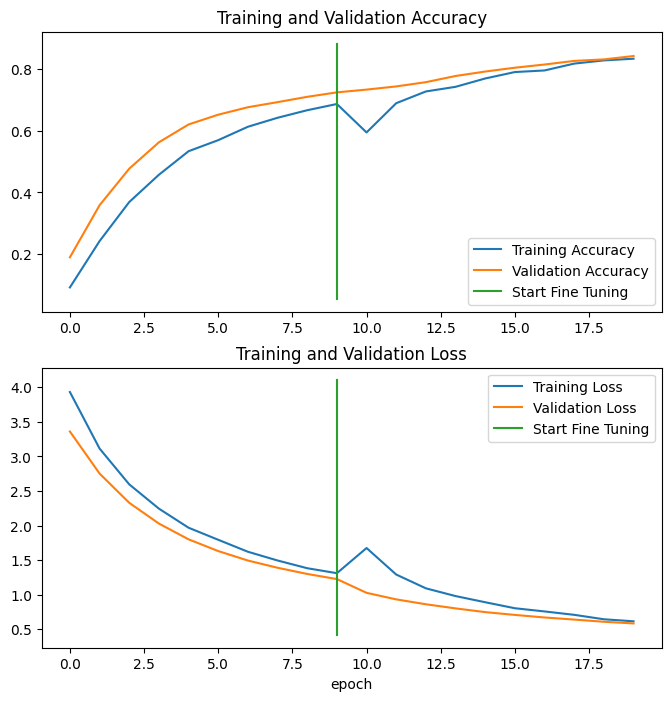

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8576 - loss: 0.5688
Test accuracy : 0.849723756313324
